In [1]:
#@title

import jax
import itertools
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
import ipywidgets as widgets

from jax.numpy.linalg import inv, pinv
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain

from tqdm import tqdm


## A simple dynamical system
Defines a discrete-time linear dynamical system with Gaussian noise that mirrors 1d kinematics.

Below $\mathbf{x}_t$ is the state, $\mathbf{w}_t$ is the perturbation.

$$ \mathbf{x}_{t+1} = A\mathbf{x}_t + \mathbf{w}_t $$ 
$$ \mathbf{y}_{t+1} = C\mathbf{x}_{t+1} + \mathbf{\epsilon}_t $$

$$ A = \begin{bmatrix}
1 & 1\\
0 & 1
\end{bmatrix}$$

$$ C = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}$$

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

fixed = False

angle = 0.2
angle2 = angle if fixed else -0.5
A = np.array([[np.cos(angle2), -np.sin(angle)], 
              [np.sin(angle), np.cos(angle2)]])
#A = -1e-4*np.eye(2)
C = np.eye(2)#0
Q = np.array([[1, 1e-4], 
              [1e-4, 1]])/100
#Q = np.eye(2)/10
R = np.array([[1, .1], 
              [.1, 1]])/10
#R = np.eye(2)
x = np.ones(2)

100%|██████████| 40/40 [00:00<00:00, 115.27it/s]


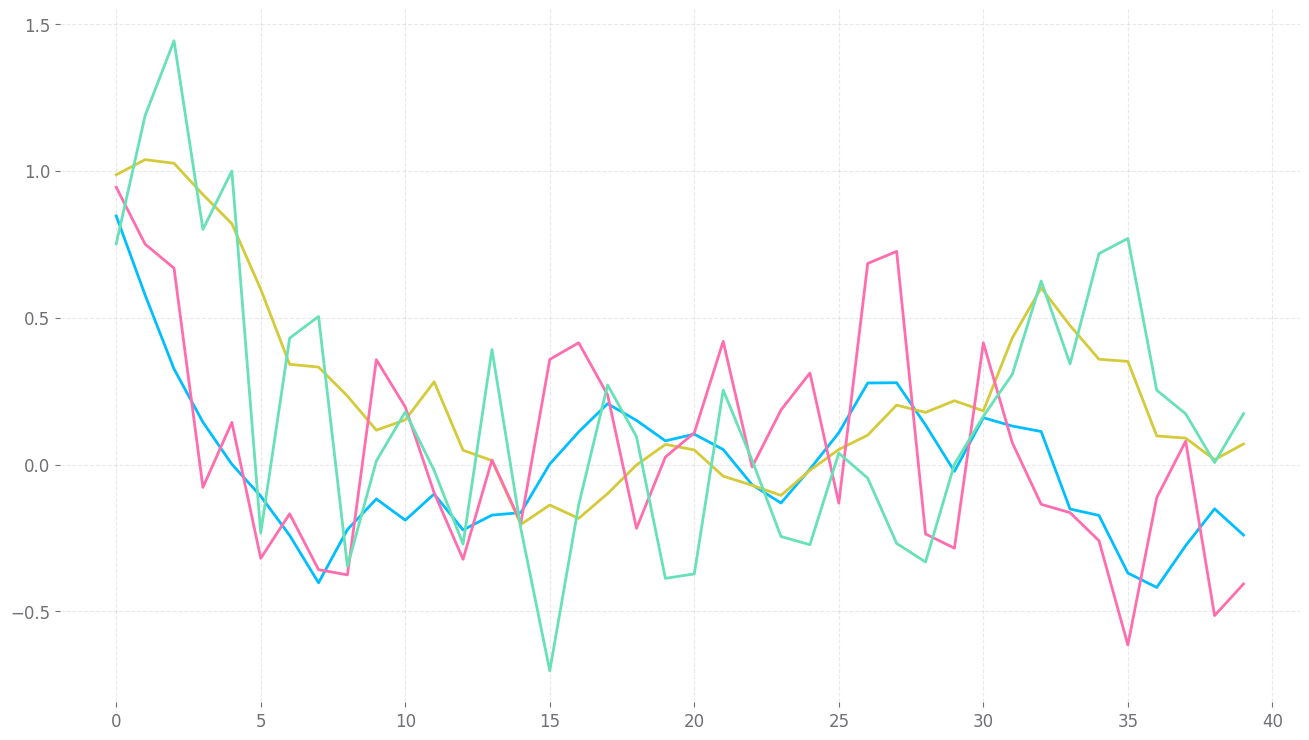

In [3]:
xs = []
ys = []
T = 40
for i in tqdm(range(T)):
    randint = onp.random.randint(0, 10000)
    x = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), mean=A@x, cov=Q)
    randint = onp.random.randint(0, 10000)
    y = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), mean=C@x, cov=R)
    xs.append(x)
    ys.append(y)
xs = np.array(xs)
ys = np.array(ys)
plt.figure(figsize=(16,9))
plt.plot(xs)
plt.plot(ys)

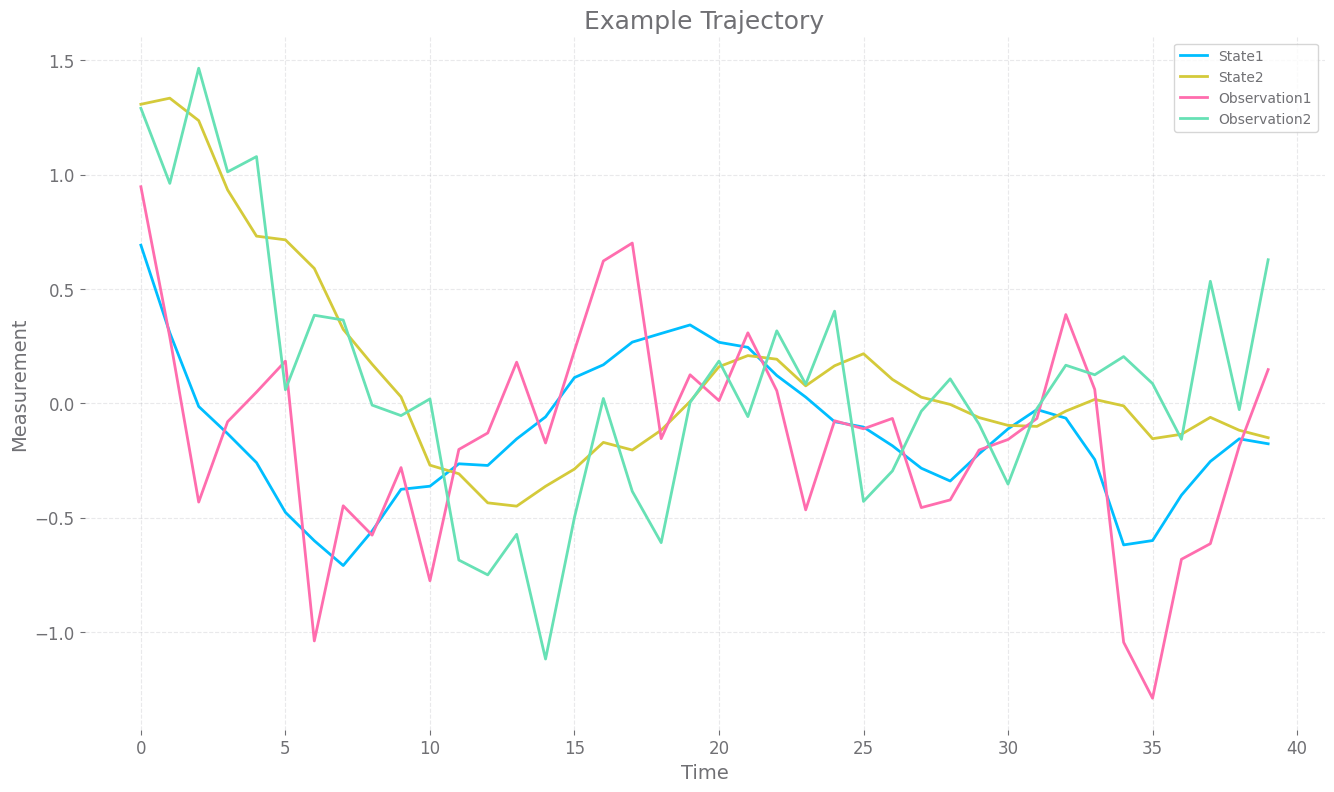

In [362]:
plt.figure(figsize=(16,9))
plt.plot(xs[:,0], label='State1')
plt.plot(xs[:,1], label='State2')
plt.plot(ys[:,0], label='Observation1')
plt.plot(ys[:,1], label='Observation2')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.title('Example Trajectory')
plt.savefig('imgs/trajs.png')

In [153]:
def rprocess(x, A, Q):
    randint = onp.random.randint(0, 10000)
    return jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), 
                                          mean=(A[None,...]@x[...,None]).squeeze(), cov=Q)

def dmeasure(y, preds, R):
    return jax.scipy.stats.multivariate_normal.logpdf(y, preds, R)

rprocess = jax.jit(rprocess)
dmeasure = jax.jit(dmeasure) #jax.jit(jax.vmap(dmeasure, in_axes=(None,0,None)))
loss_grad = (jax.vmap(jax.grad(dmeasure, argnums=1), in_axes=(None,0,None)))


        mw = np.max(weights)
        reward = mw + np.log(np.mean(np.exp(weights - mw))) # p(y_t | x_{t,1:J}, \theta)
        rewards.append(reward)
        
        if reinforce:
            log_probs = weights#[counts]
            # log_probs is shape (Np,), contains (\log p(y_t | x_{t,j}^F, \theta))_j
            baseline = np.exp(reward)
            obj += np.mean(log_probs) * np.exp(reward) #take reward to be loglik over all particles
            #obj += np.mean(log_probs * (np.exp(log_probs))) #elementwise sum reward for each particle

In [154]:
sw = False
def pfilter(angles):
    J = 1000
    randint = onp.random.randint(0, 10000)
    particlesF = jax.random.multivariate_normal(key=jax.random.PRNGKey(randint), 
                                                mean=ys[0], cov=1e-3*np.eye(xs.shape[1]),
                                                shape=(J,))
    if fixed:
        angles = angles.at[1].set(angles[0])
    A = np.array([[np.cos(angles[1]), -np.sin(angles[0])], 
            [np.sin(angles[0]), np.cos(angles[1])]])
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    
    loglik = 0
    resamples = 0
    for t in (range(T)):
        # Get prediction particles 
        particlesP = rprocess(particlesF, A, Q)# if t>0 else particlesF
        
        # Resampling condition
        if np.max(np.exp(norm_weights))/np.min(np.exp(norm_weights)) > 1e10:
            resamples += 1
            
            #counts = jax.random.categorical(key=jax.random.PRNGKey(randint), 
            #                   logits=jax.lax.stop_gradient(weights),
            #                    shape=(J,))
            
            # Systematic resampling
            unifs = jax.random.uniform(key=jax.random.PRNGKey(randint))+np.linspace(0,1,J)
            unifs = unifs.at[unifs>=1].set(unifs[unifs>=1]-1)
            counts = np.repeat(np.arange(J), 
                               np.histogram(unifs, 
                                bins=np.pad(np.cumsum(np.exp(norm_weights)), pad_width=(1,0)), 
                                    density=False)[0].astype(int))
            if len(counts)<J:
                counts = np.hstack([counts, np.zeros(J-len(counts))]).astype(int)
            
            particlesF = particlesP[counts]
        
            # Scibior and Wood
            if sw:
                # \bar{w}/stop(\bar{w}) * 1/J
                weights = norm_weights[counts] - jax.lax.stop_gradient(norm_weights[counts]) - np.log(J)
            else:
                # This is numerically unstable. Fix later
                weights = (np.log((1 + np.exp(norm_weights[counts]) 
                                   - np.exp(jax.lax.stop_gradient(norm_weights[counts])))/J))
                #log( exp(x) - exp(y) )
                #weights = (np.log(1/Np) + weights + np.log1p(-np.exp(jax.lax.stop_gradient(weights)-weights)))# - np.log(Np)
        else:
            particlesF = particlesP
            weights = norm_weights
        
        # Multiply weights by measurement model result
        weights += dmeasure(ys[t], particlesP, R) #shape (Np,)
        
        # Obtain normalized weights
        mw = np.max(weights)
        loglik_t = mw + np.log(np.sum(np.exp(weights - mw))) # p(y_t | x_{t,1:J}, \theta)
        norm_weights = weights - loglik_t
        
        # Sum up loglik
        loglik += loglik_t
        
    #print(resamples)
    return -loglik

-pfilter(np.array([0.2, -0.5]))

Array(-37.468773, dtype=float32)

In [155]:
import pykalman
kf = pykalman.KalmanFilter(transition_matrices=A, observation_matrices=C, 
                      transition_covariance=Q, observation_covariance=R)#.filter(ys)
kf.loglikelihood(ys)

-35.928806212521124

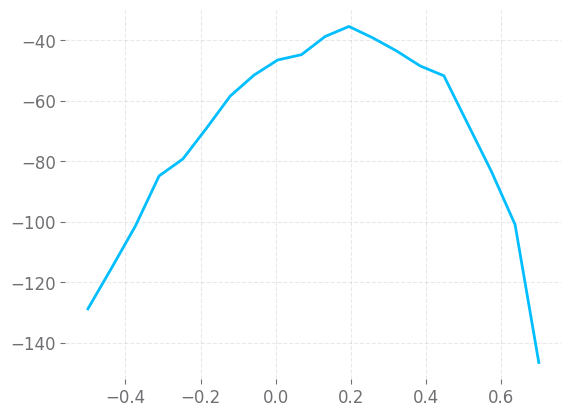

In [342]:
plt.plot(np.linspace(-0.5,0.7,20), 
         -np.array([pfilter(np.array([ang, -0.5])) 
                    for ang in np.linspace(-0.5,0.7,20)]))


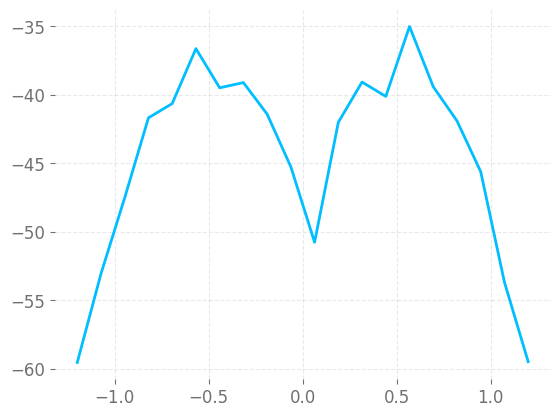

In [278]:
plt.plot(np.linspace(-1.2,1.2,20), 
         -np.array([pfilter(np.array([0.2, ang])) 
                    for ang in np.linspace(-1.2,1.2,20)]))

Text(0.5, 0, 'Iteration')

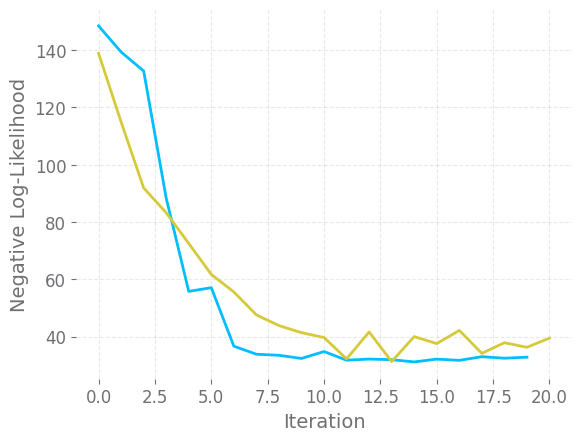

In [321]:
plt.plot(logliks)
plt.plot(loglik_grads)
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')

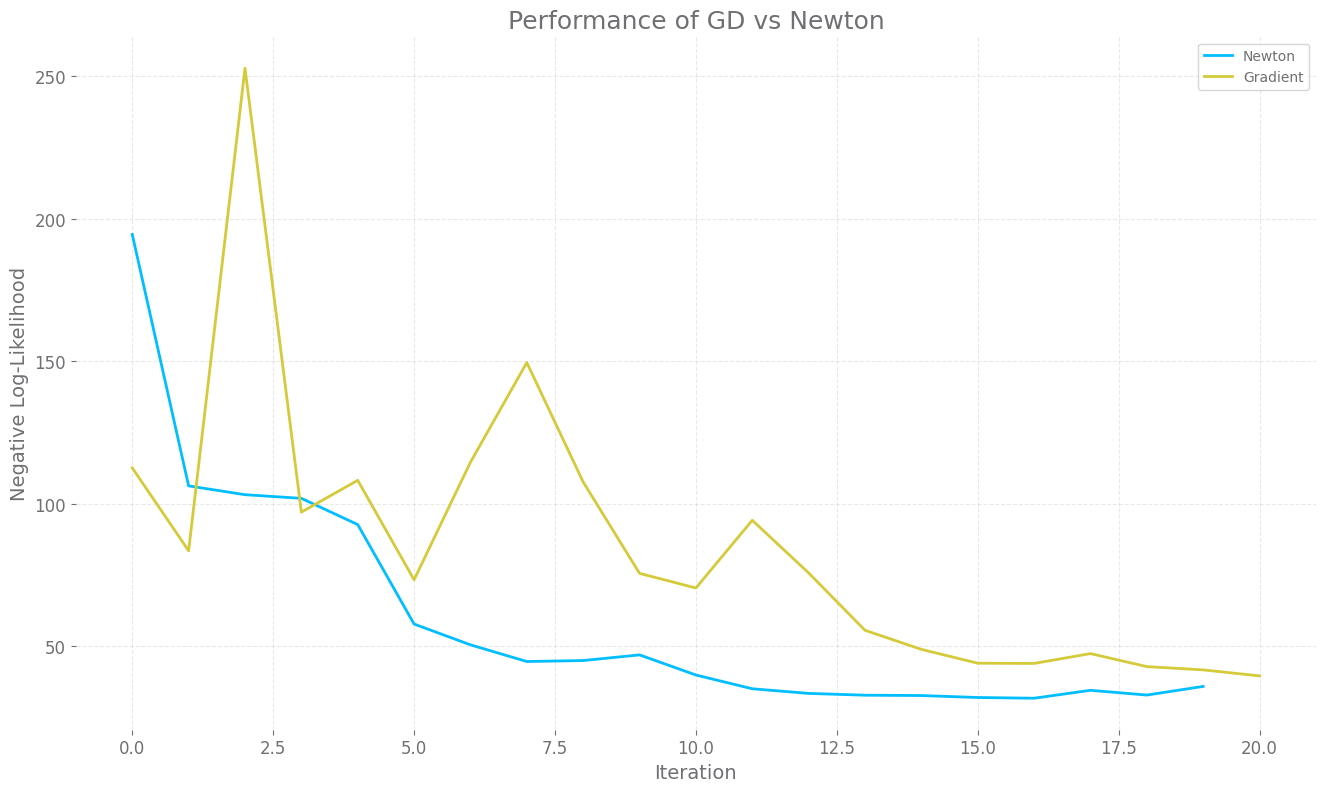

In [363]:
plt.figure(figsize=(16,9))
plt.plot(logliks, label='Newton')
plt.plot(loglik_grads, label='Gradient')
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of GD vs Newton')
plt.savefig('imgs/optim.png')

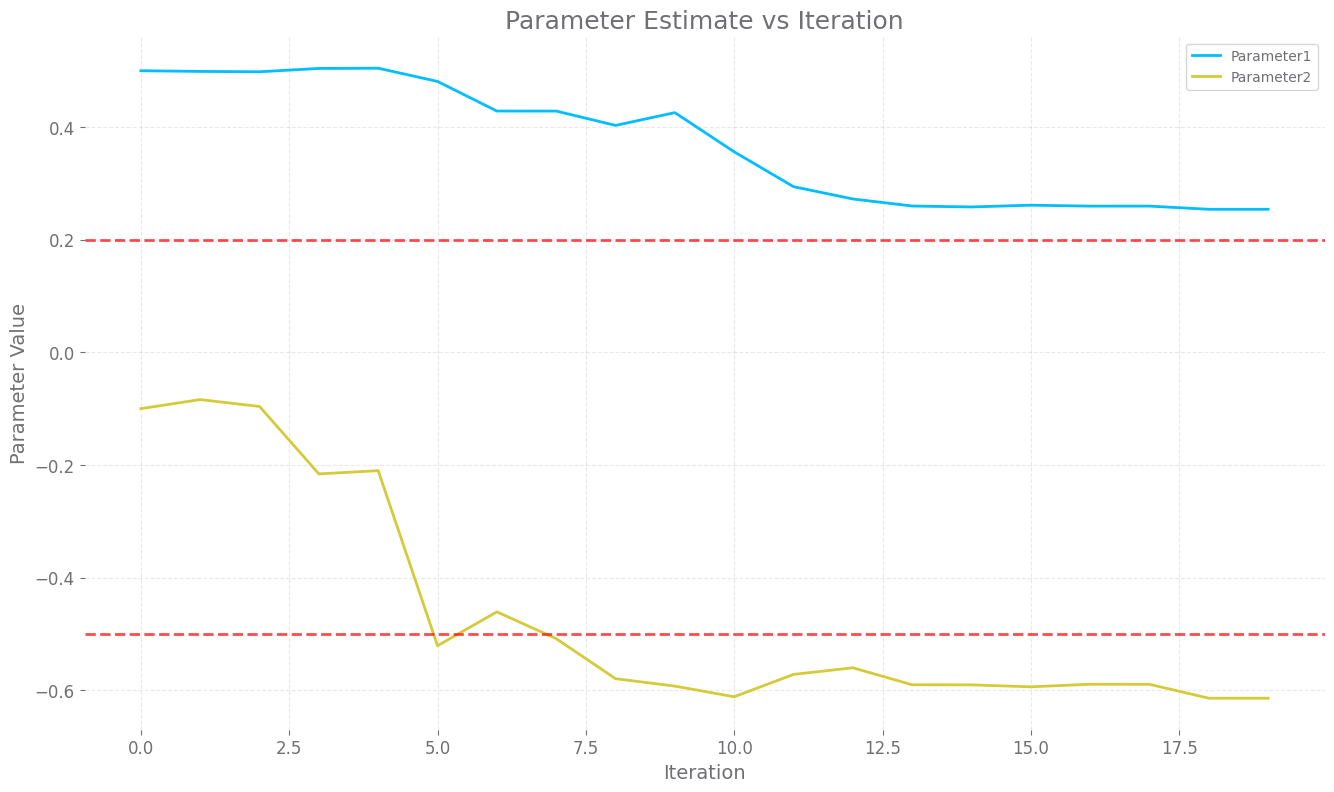

In [364]:
plt.figure(figsize=(16,9))
plt.plot(np.array(Acopies)[:,0], label='Parameter1')
plt.plot(np.array(Acopies)[:,1], label='Parameter2')
plt.axhline(angle, color='r', linestyle='--', alpha=0.7)
plt.axhline(angle2, color='r', linestyle='--', alpha=0.7)
plt.title('Parameter Estimate vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend()
plt.savefig('imgs/params.png')

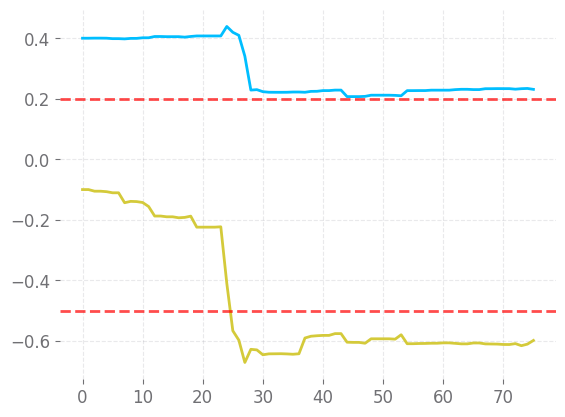

In [191]:
plt.plot(np.array(Acopies))
plt.axhline(angle, color='r', linestyle='--', alpha=0.7)
plt.axhline(angle2, color='r', linestyle='--', alpha=0.7)

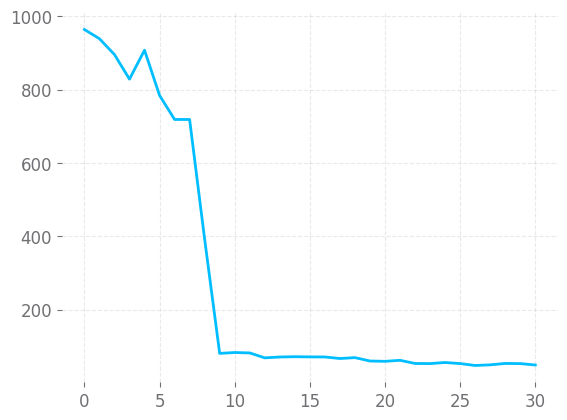

In [147]:
plt.plot(logliks)
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')

In [ ]:
#Variance dependence on horizon
angles = np.array([0.4, -0.1])
space = np.linspace(3,T,10).astype(int)
stds = []
stdsw = []
for i in tqdm(space):
    T = i
    sw = False
    stds.append(np.std(np.array([jax.grad(pfilter)(angles) for i in range(100)])))
    sw = True
    stdsw.append(np.std(np.array([jax.grad(pfilter)(angles) for i in range(100)])))
T = space[-1]
stds = np.array(stds)
stdsw = np.array(stdsw)

#plt.plot(np.array(stds).reshape(len(stds),4))
plt.figure(figsize=(16,9))
plt.plot(space,(stds)**2, label='log subtract')
plt.plot(space,(stdsw)**2, label='scibior wood')
plt.legend()

 50%|█████     | 5/10 [02:14<02:48, 33.67s/it]

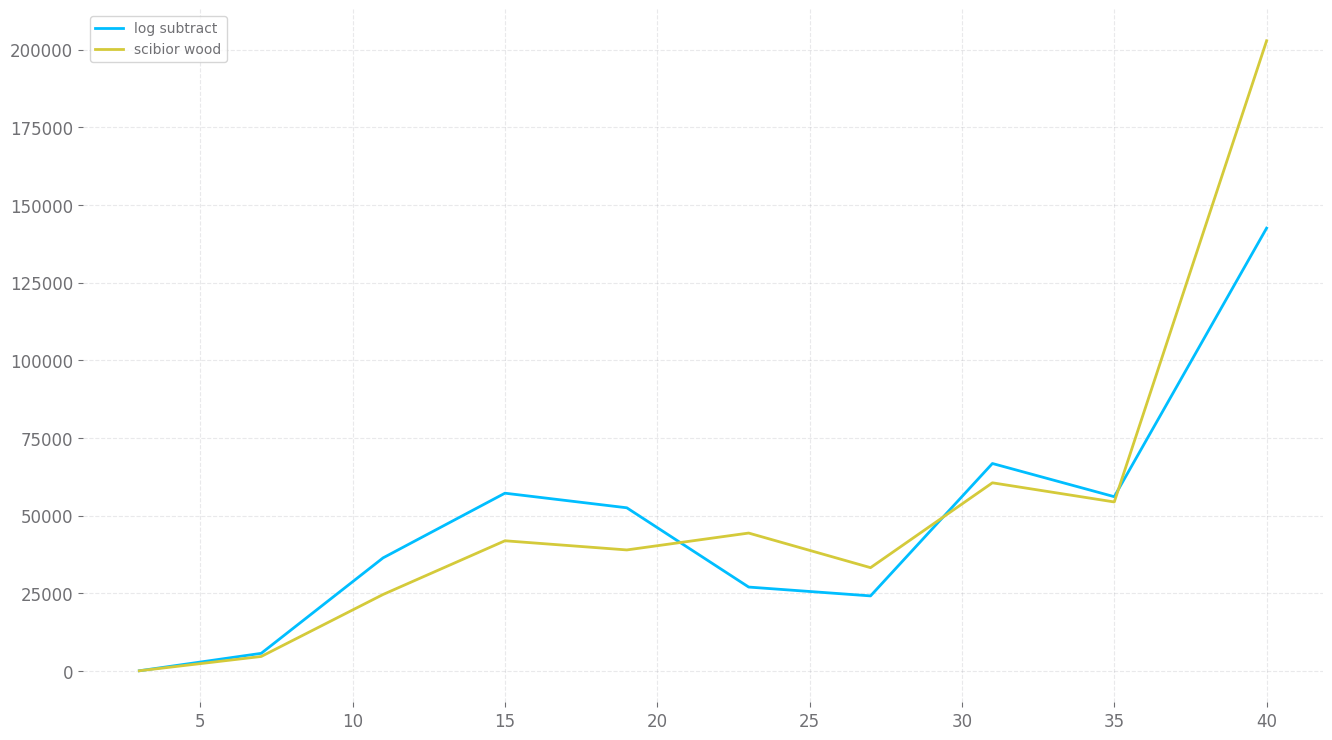

In [359]:
plt.figure(figsize=(16,9))
plt.plot(space,(stds)**2, label='log subtract')
plt.plot(space,(stdsw)**2, label='scibior wood')
plt.legend()

In [360]:
#Variance dependence on horizon
angles = np.array([0.4, -0.1])
space = np.linspace(3,T,10).astype(int)
stds_grad = []
stds_hess = []
for i in tqdm(space):
    T = i
    sw = True
    stds_grad.append(np.array([jax.hessian(pfilter)(angles) for i in range(100)]))
    sw = True
    stds_hess.append(np.array([jax.hessian(pfilter)(angles) for i in range(100)]))
T = space[-1]
stds_grad = np.array(stds_grad)
stds_hess = np.array(stds_hess)


100%|██████████| 10/10 [13:12<00:00, 79.24s/it] 


In [317]:
# From https://arxiv.org/pdf/1909.01238.pdf
def line_search(obj, curr_obj, pt, grad, direction, k=1, eta=0.9, xi=10, tau = 20, c=0.1, frac=0.5, stoch=False):
    itn = 0
    eta = min([eta, xi/k]) if stoch else eta
    while obj(pt + eta*direction) > curr_obj + eta*c*grad.T @ direction:
        eta *= frac
        itn += 1
        if itn > tau:
            break
    return eta

In [ ]:
sw = True

Acopies = []
grads = []
hesses = []
logliks = []

etas = [1e-4,1e-3,1e-2,1e-1,0.2,0.5,0.9]

angles = np.array([0.5, -0.1])

for i in tqdm(range(100)):
    grad = jax.grad(pfilter)(angles)
    hess = jax.hessian(pfilter)(angles)
    loglik = pfilter(angles)
    
    Acopies.append(angles)
    logliks.append(loglik)
    grads.append(grad)
    hesses.append(hess)
    
    #eta = etas[np.argmin(np.array([pfilter(angles - et*np.linalg.pinv(hess) @ grad) for et in etas]))]
    direction = -np.linalg.pinv(hess) @ grad
    eta = line_search(pfilter, loglik, angles, grad, direction, k=i+1, eta=0.9)
    
    if i%1==0:
        print(angles, eta, logliks[i])
        
    angles += eta*direction
    #angles -= eta*np.linalg.pinv(hess) @ grad

In [331]:
sw = True

Acopies_grads = []
grads_grads = []
loglik_grads = []

etas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0.2,0.5,0.9]

angles = np.array([0.5, -0.1])

for i in tqdm(range(100)):
    grad = jax.grad(pfilter)(angles)
    
    Acopies_grads.append(angles)
    loglik_grads.append(pfilter(angles))
    grads_grads.append(grad)
    
    #eta = etas[np.argmin(np.array([pfilter(angles - et*grad) for et in etas]))]
    direction = -grad
    #eta = line_search(pfilter, loglik, angles, grad, direction, beta=1, eta=1e-2)
    
    if i%1==0:
        print(angles, eta, loglik_grads[i])
    if i == len(logliks):
        break
        
    angles += 5e-2*direction/np.linalg.norm(direction)
    #angles -= eta * grad

  1%|          | 1/100 [00:00<01:07,  1.47it/s]

[ 0.5 -0.1] 0.45 112.638596


  2%|▏         | 2/100 [00:01<01:02,  1.56it/s]

[ 0.45020595 -0.10453349] 0.45 83.54693


  3%|▎         | 3/100 [00:02<01:05,  1.49it/s]

[ 0.49984026 -0.11056979] 0.45 252.8979


  4%|▍         | 4/100 [00:02<01:02,  1.53it/s]

[ 0.45020667 -0.10452775] 0.45 97.11773


  5%|▌         | 5/100 [00:03<01:01,  1.55it/s]

[ 0.4965487  -0.12330049] 0.45 108.274826


  6%|▌         | 6/100 [00:03<01:00,  1.57it/s]

[ 0.44701627 -0.11647869] 0.45 73.36601


  7%|▋         | 7/100 [00:04<01:09,  1.34it/s]

[ 0.49701595 -0.11629674] 0.45 114.62419


  8%|▊         | 8/100 [00:05<01:08,  1.35it/s]

[ 0.5456912  -0.12773007] 0.45 149.60558


  9%|▉         | 9/100 [00:06<01:05,  1.40it/s]

[ 0.4957834  -0.13076511] 0.45 107.69755


 10%|█         | 10/100 [00:06<01:01,  1.46it/s]

[ 0.44730493 -0.11852418] 0.45 75.62175


 11%|█         | 11/100 [00:07<00:59,  1.50it/s]

[ 0.40010452 -0.13502027] 0.45 70.48977


 12%|█▏        | 12/100 [00:08<00:57,  1.53it/s]

[ 0.44691205 -0.15260027] 0.45 94.25127


 13%|█▎        | 13/100 [00:08<00:56,  1.55it/s]

[ 0.39757437 -0.16071162] 0.45 75.77655


 14%|█▍        | 14/100 [00:09<00:52,  1.63it/s]

[ 0.35195974 -0.18118855] 0.45 55.65015


 15%|█▌        | 15/100 [00:09<00:50,  1.69it/s]

[ 0.30624333 -0.20143728] 0.45 48.95104


 16%|█▌        | 16/100 [00:10<00:47,  1.75it/s]

[ 0.2564991 -0.2064882] 0.45 44.100502


 17%|█▋        | 17/100 [00:10<00:46,  1.78it/s]

[ 0.2065703  -0.20915538] 0.45 44.012165


 18%|█▊        | 18/100 [00:11<00:45,  1.80it/s]

[ 0.2565198 -0.2114018] 0.45 47.464157


 19%|█▉        | 19/100 [00:11<00:44,  1.83it/s]

[ 0.20686115 -0.21723439] 0.45 42.904495


 20%|██        | 20/100 [00:12<00:43,  1.86it/s]

[ 0.19844684 -0.2665213 ] 0.45 41.74979


 20%|██        | 20/100 [00:12<00:51,  1.54it/s]

[ 0.2077302  -0.31565195] 0.45 39.64129
